# Simulation de Dépacement 2D - 2

In [47]:
import numpy as np
import numpy.linalg as nplin
# from scipy.integrate import odeint

from IPython.display import Image

Ce notebook simule le déplacement d'un floe en 2D. Cette fois, le floes est immobilisé en ses extrémitées $\text{q}_1$ et $\text{q}_2$. 

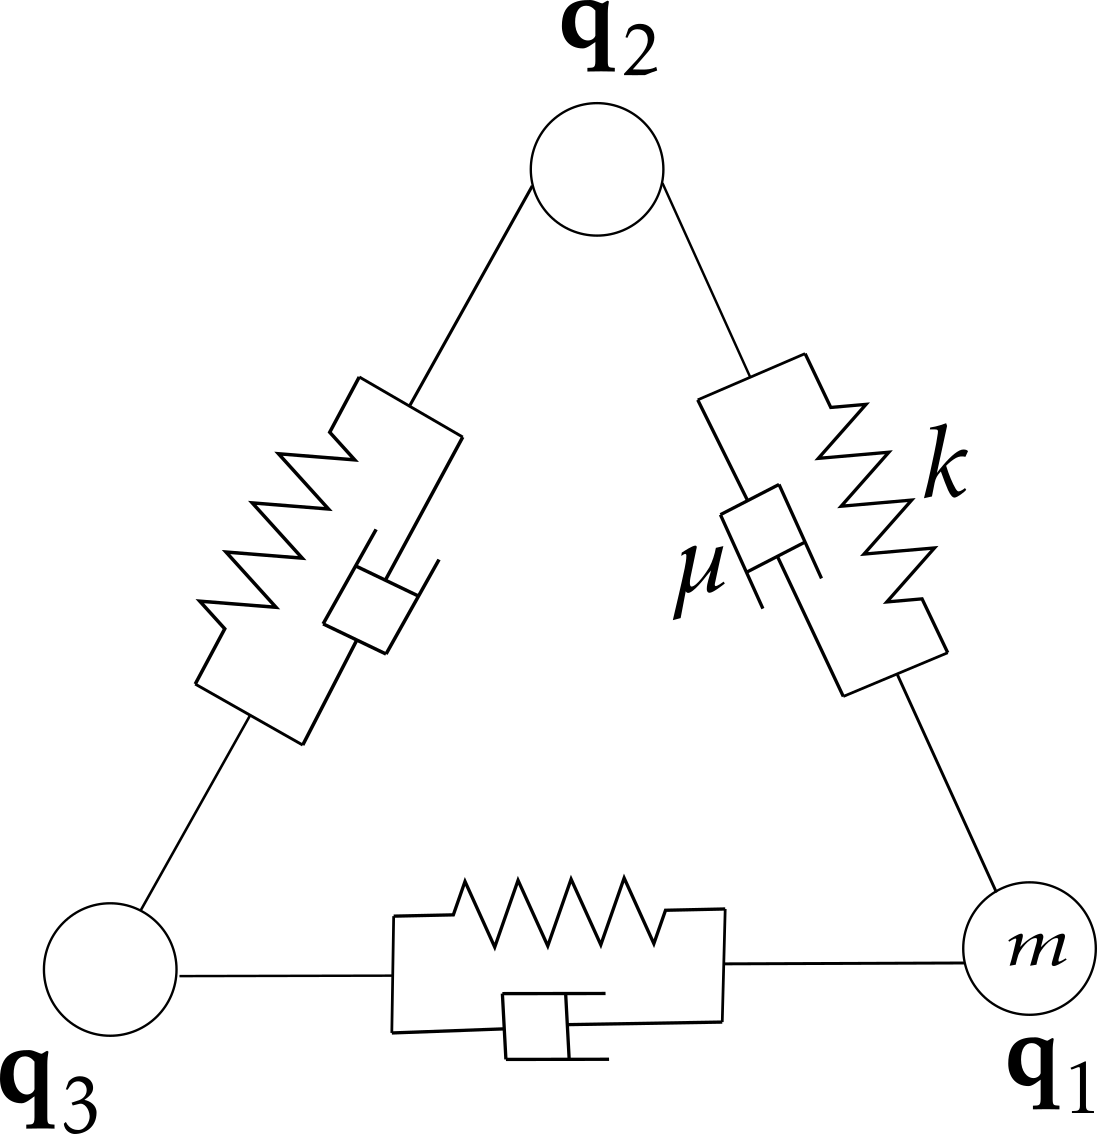

In [48]:
Image("../../reports/internship/Figures/Deplacement2D-1.png", width=300)  ## Changer l'image, montrer l'imobilisation

## Interactive plot

Observons un plot interactif dans lesquel on pourra faire varier les paramètres du modèle. Il faudra installer le package [Bokeh](https://bokeh.org/) en plus de matplotlib pour que ca fonctionne.

In [49]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge, ConnectionPatch
from matplotlib.collections import PatchCollection

from ipywidgets import interact

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [50]:
## Des fonction pour le dessin du réseau

def makeScene(nbAx=1):                         ## Pour faire des plots en horizontale
    fig, ax = plt.subplots(1, nbAx, figsize=(6.4*nbAx, 4.8))
    if nbAx == 1:
      ax.set_xlim([-5,5])
      ax.set_ylim([-5,5])
      ax.set_aspect('equal', adjustable='box')
    else:
      for axis in ax:
        axis.set_xlim([-5,5])
        axis.set_ylim([-5,5])
        axis.set_aspect('equal', adjustable='box');
    return ax

ax = makeScene(2);
def update_axis(ax, q1, q2, q3, title="Positions"):
    ax.add_patch(Circle(q1, radius=0.2, alpha=0.5, fc=(1,0.1,0.1), ec='k'));
    ax.add_patch(Circle(q2, radius=0.2, alpha=0.5, fc=(0.1,1,0.1), ec='k'));
    ax.add_patch(Circle(q3, radius=0.2, alpha=0.5, fc=(0.1,0.1,1), ec='k'));

    ax.add_artist(ConnectionPatch(xyA = q1, coordsA = ax.transData, xyB = q2, coordsB = ax.transData, arrowstyle ="-"))
    ax.add_artist(ConnectionPatch(xyA = q2, coordsA = ax.transData, xyB = q3, coordsB = ax.transData, arrowstyle ="-"))
    ax.add_artist(ConnectionPatch(xyA = q1, coordsA = ax.transData, xyB = q3, coordsB = ax.transData, arrowstyle ="-"))
    
    ax.set_title(title)

# update_axis(ax[0], q1_0, q2_0, q3_0)
# update_axis(ax[1], q1_f, q2_f, q3_f)
plt.close()

In [51]:
## Nombre de noeuds
nb_nodes = 3

N = 5000
T = 5.0
dt = T/N
t = np.linspace(0,T, N+1)
q = np.zeros(shape=(nb_nodes, N+1, 2))

p = figure(title="Plot des déplacements et vitesses",
           plot_height=500, plot_width=1000, y_range=(-1,1),background_fill_color='#efefef')

q1x = p.line(t, q[0,:,0], color="blue", line_width=1.5, alpha=0.8, legend_label='q₁,ₓ')
q2x = p.line(t, q[1,:,0], color="orange", line_width=1.5, alpha=0.8, legend_label='q₂,ₓ')
q3x = p.line(t, q[2,:,0], color="violet", line_width=1.5, alpha=0.8, legend_label='q₃,ₓ')

q1y = p.line(t, q[0,:,1], color="green", line_width=1.5, alpha=0.8, legend_label='q₁,ᵧ')
q2y = p.line(t, q[1,:,1], color="red", line_width=1.5, alpha=0.8, legend_label='q₂,ᵧ')
q3y = p.line(t, q[2,:,1], color="black", line_width=1.5, alpha=0.8, legend_label='q₃,ᵧ')

# p.legend.visible = False
p.legend.label_text_font_style = "italic"

In [55]:
def update(m=6.2, k=23.3, mu=3.0, v1=0.0, v2=0.0, v3=0.1,
           theta1=180, theta2=270, theta3=0,
           q1_0x=0.9, q2_0x=0.5, q3_0x=-0.5, q1_0y=0, q2_0y=0.5, q3_0y=0,
           T=1.0):

    ## Complètement optionel
    dt = T/N

    ## Matrice de connectivité
    C = np.ones((nb_nodes, nb_nodes), dtype=int)
    for i in range(nb_nodes): C[i,i] = 0

    ## Positions initiales
    q = np.zeros((nb_nodes, N+1, 2))

    q1_0 = np.array([q1_0x, q1_0y])
    q2_0 = np.array([q2_0x, q2_0y])
    q3_0 = np.array([q3_0x, q3_0y])

    q[0,0,:] = q1_0
    q[1,0,:] = q2_0
    q[2,0,:] = q3_0

    q[0,1,:] = q1_0 + dt*np.array([v1*np.cos(np.deg2rad(theta1)), v1*np.sin(np.deg2rad(theta1))])
    q[1,1,:] = q2_0 + dt*np.array([v2*np.cos(np.deg2rad(theta2)), v2*np.sin(np.deg2rad(theta2))])
    q[2,1,:] = q3_0 + dt*np.array([v3*np.cos(np.deg2rad(theta3)), v3*np.sin(np.deg2rad(theta3))])

    ## Vecteurs unitaires initiaux
    u = np.zeros((nb_nodes, nb_nodes, 2))

    ## Longueurs des ressorts au repos
    L = np.zeros((nb_nodes, nb_nodes), dtype=float)
    for i in range(nb_nodes):       ## Optimisable
        for j in range(nb_nodes):
            L[i,j] = nplin.norm(q[i,0]-q[j,0])

    ## Boucle de résolution
    for n in range(1,N):
        ## Les points 1 et 2 est imobile tout ce temps
        q[0,n+1] = q[0,1,:]
        q[1,n+1] = q[1,1,:]
        
        for i in range(2, nb_nodes):
            ## Mise à jour des positions
            q[i,n+1] = 2*q[i,n] - q[i,n-1]

            for i_ in range(i+1, i+3):   ## Optimisable
                j = i_ % nb_nodes

                ## Mise à jour des vecteurs unitaires
                u[i,j] = (q[j,n] - q[i,n]) / nplin.norm(q[i,n] - q[j,n])

                ## Mise à jour des positions
                q[i,n+1] += (dt*dt / m)*C[i,j]*( k*(nplin.norm(q[j,n]-q[i,n]) - L[i,j])*u[i,j]
                                                 +  (mu/dt)*(np.dot(q[j,n]-q[j,n-1]-q[i,n]+q[i,n-1], u[i,j]))*u[i,j] )
                
    q1x.data_source.data['y'] = q[0,:,0]
    q2x.data_source.data['y'] = q[1,:,0]
    q3x.data_source.data['y'] = q[2,:,0]

    q1y.data_source.data['y'] = q[0,:,1]
    q2y.data_source.data['y'] = q[1,:,1]
    q3y.data_source.data['y'] = q[2,:,1]

    print("\nPositions initiales:", q1_0, q2_0, q3_0)
    print("Positions finales:", q[0,-1,:], q[1,-1,:], q[2,-1,:])
    ## Mise a jour des positions pour le plot
    print()
    ax = makeScene(2)
    update_axis(ax[0], q1_0, q2_0, q3_0, title="Positions initiales")
    update_axis(ax[1], q[0,-1,:], q[1,-1,:], q[2,-1,:], title="Positions finales")
    plt.show()

    push_notebook()

In [56]:
show(p, notebook_handle=True)

In [57]:
interact(update, m=(-0,10,0.1), k=(-0,30,0.1), mu=(-0,10,0.1),
            v1=(-5,5,0.1), v2=(-5,5,0.1), v3=(-5,5,0.1),
            theta1=(0, 360, 30), theta2=(0, 360, 30), theta3=(0, 360, 30),
            q1_0x=(-10, 10, 0.5), q2_0x=(-10, 10, 0.5), q3_0x=(-10, 10, 0.5),
            q1_0y=(-10, 10, 0.5), q2_0y=(-10, 10, 0.5), q3_0y=(-10, 10, 0.5),
            T=(0,32,1));

interactive(children=(FloatSlider(value=6.2, description='m', max=10.0), FloatSlider(value=23.3, description='…

En somme,